# <a href="https://girafe.ai/" target="_blank" rel="noopener noreferrer"><img src="https://raw.githubusercontent.com/girafe-ai/ml-course/7096a5df4cada5ee651be1e3215c2f7fb8a7e0bf/logo_margin.svg" alt="girafe-ai logo" width="150px" align="left"></a> [ml-basic course](https://github.com/girafe-ai/ml-course) <a class="tocSkip">

# Lab assignment №2, part 1
## Gradient boosting on temporal data and feature importances

Today we will work with Gradient Boosting library. It is one of the most popular models these days that shows both great quality and performance.

Choises for library are:

* [LightGBM](https://github.com/Microsoft/LightGBM) by Microsoft. Handful and fast.
* [Catboost](https://github.com/catboost/catboost) by Yandex. Tuned to deal well with categorical features.
* [xgboost](https://github.com/dmlc/xgboost) by dlmc. The most famous framework which got very popular on kaggle.

**Dataset**

By default we will work with widely known [Human Actividy Recognition (HAR) dataset](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones). Data is available at UCI repository.

There are available both raw and preprocessed datasets. This time we will use the preprocessed one.
Some simple preprocessing is done for you.

If you want more interpretable data, you can take [Wine quality dataset](https://archive.ics.uci.edu/dataset/186/wine+quality) (see details below).

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset and try to get some useful insights on the features the model paid attention to.

## Part 0. Downloading and preprocessing

The preprocessing is done for you. Let's take a look at the data:

In [1]:
# # Download and unpack dataset from UCI
# !wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
# !unzip -u "UCI HAR Dataset.zip" "UCI HAR Dataset/train/X_train.txt" "UCI HAR Dataset/train/y_train.txt" \
# "UCI HAR Dataset/test/X_test.txt" "UCI HAR Dataset/test/y_test.txt" "UCI HAR Dataset/activity_labels.txt"

In [2]:

# import zipfile
# import os

# url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip'
# zip_path = 'UCI HAR Dataset.zip'
# if not os.path.exists(url):
#     urllib.request.urlretrieve(url, zip_path)

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(".")

In [3]:
!pip install -q catboost
!pip install -q optuna

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import catboost
import numpy as np
import pandas as pd
import optuna

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


In [5]:
base = '/kaggle/input/ucihar-dataset/UCI-HAR Dataset'
X_train = np.genfromtxt(f"{base}/train/X_train.txt")
y_train = np.genfromtxt(f"{base}/train/y_train.txt")
print(f"Train set: {X_train.shape}, {y_train.shape}")

X_test = np.genfromtxt(f"{base}/test/X_test.txt")
y_test = np.genfromtxt(f"{base}/test/y_test.txt")
print(f"Test set: {X_test.shape}, {y_test.shape}")

n_features = X_train.shape[1]

Train set: (7352, 561), (7352,)
Test set: (2947, 561), (2947,)


In [6]:
activity_labels = {}
with open(f"{base}/activity_labels.txt", "r") as file:
    for line in file:
        label, name = line.strip().split(" ")
        activity_labels[int(label)] = name

activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

Let's normalize data

In [7]:
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean) / data_std
X_test = (X_test - data_mean) / data_std

The dataset has some duplicating features. Let's remove them

In [8]:
# fmt: off
duplicating_columns = (
    205, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 231, 244, 257, 507, 520, 533, 546,
)
# fmt: on

duplicating_mask = np.isin(range(n_features), duplicating_columns)

In [9]:
X_train_unique = X_train[:, ~duplicating_mask]
X_test_unique = X_test[:, ~duplicating_mask]

X_train_unique.shape, X_test_unique.shape

((7352, 540), (2947, 540))

PCA could be useful in this case. E.g.

In [10]:
from sklearn.decomposition import PCA

In [11]:
pca = PCA(0.95)

X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

X_train_pca.shape, X_test_pca.shape

((7352, 103), (2947, 103))

Text(0, 0.5, 'Principal component 2')

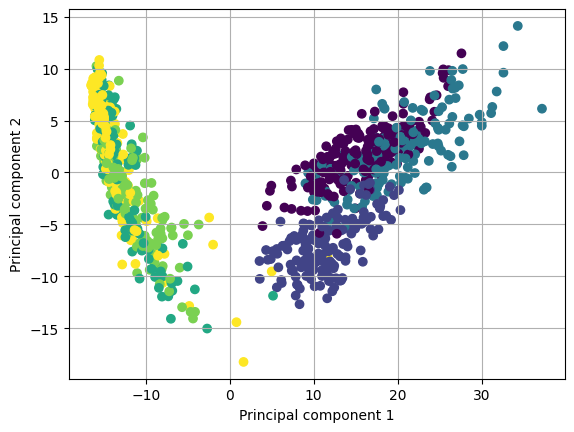

In [12]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")

Text(0, 0.5, 'Principal component 5')

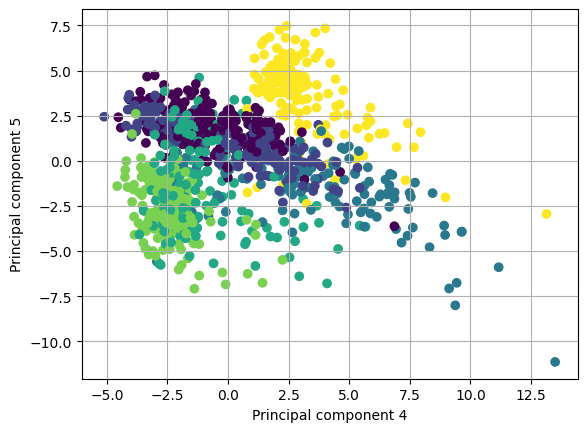

In [13]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 4")
plt.ylabel("Principal component 5")

In [14]:
df_test = pd.DataFrame(y_train)
df_train = pd.DataFrame(y_test)

df_test.value_counts()

0  
6.0    1407
5.0    1374
4.0    1286
1.0    1226
2.0    1073
3.0     986
Name: count, dtype: int64

In [15]:
df_train.value_counts()

0  
6.0    537
5.0    532
1.0    496
4.0    491
2.0    471
3.0    420
Name: count, dtype: int64

### Alternative dataset: Wine quality

Please, take this dataset if you are sure you can preprocess it yourself and ready to work with it's features and results, so it is done on your risk.

However you will have interpretable features which can be analysed with shap in last part

## Part 1. Fit the model.

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to approximate them by yourself.

In this part just check some (3-5) sets of hyperparameters by hand.

In [16]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)


In [17]:
from catboost import CatBoostClassifier
model1 = CatBoostClassifier(
    iterations = 1700 ,
    learning_rate = 0.3 ,
    task_type="GPU",
    devices = '0'
)

model1.fit(X_tr,
          y_tr,
          eval_set=[(X_val, y_val)],
          early_stopping_rounds=100,
          use_best_model = True,
          verbose = 100,
          plot = False
          )
# Example: https://rpubs.com/burakh/har_xgb

0:	learn: 0.9117363	test: 0.8905545	best: 0.8905545 (0)	total: 15.6s	remaining: 7h 22m 10s
100:	learn: 0.0233681	test: 0.0470124	best: 0.0470124 (100)	total: 16.7s	remaining: 4m 23s
200:	learn: 0.0095661	test: 0.0326813	best: 0.0326813 (200)	total: 17.7s	remaining: 2m 12s
300:	learn: 0.0055247	test: 0.0276640	best: 0.0273683 (296)	total: 18.7s	remaining: 1m 27s
400:	learn: 0.0036666	test: 0.0248673	best: 0.0248230 (399)	total: 19.8s	remaining: 1m 4s
500:	learn: 0.0026696	test: 0.0233017	best: 0.0233017 (500)	total: 20.8s	remaining: 49.8s
600:	learn: 0.0020558	test: 0.0223079	best: 0.0223079 (600)	total: 21.8s	remaining: 39.9s
700:	learn: 0.0016498	test: 0.0213917	best: 0.0213083 (687)	total: 22.9s	remaining: 32.6s
800:	learn: 0.0013835	test: 0.0208035	best: 0.0207986 (796)	total: 23.9s	remaining: 26.8s
900:	learn: 0.0011828	test: 0.0202397	best: 0.0202037 (899)	total: 24.9s	remaining: 22.1s
1000:	learn: 0.0010076	test: 0.0195073	best: 0.0195073 (1000)	total: 26s	remaining: 18.1s
1100:	

In [18]:
from sklearn.metrics import accuracy_score, classification_report, f1_score
y_pred = model1.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Test accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred))


Test accuracy: 0.9376
              precision    recall  f1-score   support

         1.0       0.94      0.97      0.96       496
         2.0       0.91      0.93      0.92       471
         3.0       0.98      0.91      0.94       420
         4.0       0.93      0.86      0.89       491
         5.0       0.88      0.94      0.91       532
         6.0       1.00      1.00      1.00       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



## Part 2. Use hyper parameter tuning system

Use [optuna](https://optuna.org/), [hyperopt](http://hyperopt.github.io/hyperopt/) or any other zero order optimizer to find optimal hyper param set.

In [19]:
def optimize(trial):

    params = {
        "iterations": 1500, 
        "depth": trial.suggest_categorical("depth", [6, 7, 8]), # bigger than 8 or 10 overfits the data very quickly if learning rate is also high
        "learning_rate": trial.suggest_float(
            "learning_rate", 0.03, 0.2
        ),
        "task_type": "GPU", # use gpu
        "devices":'0', # use only the first gpu
        "random_seed": 42,  # each time gives the  same output
        "verbose": 0, # do not print results
    }

    model = CatBoostClassifier(**params)

    model.fit(
        X_tr, y_tr,
        eval_set=(X_val, y_val),
        early_stopping_rounds=100,
        use_best_model=True
    )

    preds = model.predict(X_val).flatten()
    return  f1_score(y_val, preds, average="macro") # f1 score used here because our classes are slightly imbalanced


In [20]:
study = optuna.create_study(direction="maximize")
study.optimize(optimize, n_trials=5)

[I 2025-12-21 18:54:15,446] A new study created in memory with name: no-name-048a23c6-f003-4ec4-9832-63939804f30a
[I 2025-12-21 18:54:33,230] Trial 0 finished with value: 0.9948444177783736 and parameters: {'depth': 6, 'learning_rate': 0.1652714761518229}. Best is trial 0 with value: 0.9948444177783736.
[I 2025-12-21 18:54:59,886] Trial 1 finished with value: 0.9956084335999642 and parameters: {'depth': 7, 'learning_rate': 0.17585959590800052}. Best is trial 1 with value: 0.9956084335999642.
[I 2025-12-21 18:55:26,297] Trial 2 finished with value: 0.9956071903358188 and parameters: {'depth': 7, 'learning_rate': 0.1728126688827958}. Best is trial 1 with value: 0.9956084335999642.
[I 2025-12-21 18:55:44,063] Trial 3 finished with value: 0.9962352807971014 and parameters: {'depth': 6, 'learning_rate': 0.180940034096883}. Best is trial 3 with value: 0.9962352807971014.
[I 2025-12-21 18:56:26,567] Trial 4 finished with value: 0.99421760183869 and parameters: {'depth': 8, 'learning_rate': 0.

In [21]:
best_model = CatBoostClassifier(
    **study.best_params,
    random_seed=42,
    task_type='GPU',
    devices = '0',
    verbose=100
)

best_model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    use_best_model=True
)

0:	learn: 1.1830931	test: 1.2390618	best: 1.2390618 (0)	total: 15.3ms	remaining: 15.2s
100:	learn: 0.0379899	test: 0.2109333	best: 0.2109333 (100)	total: 1.1s	remaining: 9.77s
200:	learn: 0.0175511	test: 0.1869349	best: 0.1869349 (200)	total: 2.17s	remaining: 8.61s
300:	learn: 0.0107709	test: 0.1776245	best: 0.1775766 (299)	total: 3.2s	remaining: 7.44s
400:	learn: 0.0069155	test: 0.1731955	best: 0.1731955 (400)	total: 4.23s	remaining: 6.32s
500:	learn: 0.0050265	test: 0.1700272	best: 0.1698641 (490)	total: 5.32s	remaining: 5.29s
600:	learn: 0.0039237	test: 0.1668369	best: 0.1666323 (597)	total: 6.34s	remaining: 4.21s
700:	learn: 0.0030746	test: 0.1655315	best: 0.1647639 (673)	total: 7.37s	remaining: 3.15s
800:	learn: 0.0025052	test: 0.1657078	best: 0.1641316 (778)	total: 8.41s	remaining: 2.09s
900:	learn: 0.0021034	test: 0.1664702	best: 0.1641316 (778)	total: 9.44s	remaining: 1.04s
999:	learn: 0.0018365	test: 0.1678290	best: 0.1641316 (778)	total: 10.4s	remaining: 0us
bestTest = 0.1641

In [22]:
#Print the best parameteres 
print("Best f1 score:", study.best_value)
print("Best parameters:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")


Best f1 score: 0.9962352807971014
Best parameters:
depth: 6
learning_rate: 0.180940034096883


In [23]:
test_preds = best_model.predict(X_test)
print("TEST ACC: ", accuracy_score(y_test, test_preds))
print("F1 score: ",f1_score(y_test, test_preds, average='macro'))
print(classification_report(y_test, test_preds))

TEST ACC:  0.9379029521547336
F1 score:  0.9375666990252357
              precision    recall  f1-score   support

         1.0       0.94      0.97      0.95       496
         2.0       0.92      0.94      0.93       471
         3.0       0.98      0.93      0.95       420
         4.0       0.93      0.85      0.89       491
         5.0       0.87      0.94      0.91       532
         6.0       1.00      1.00      1.00       537

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



### Conclusion

Please, write down your thoughts on the experiment results:  
class 4 (standing) is lower on recal and class 5 (sitting) is lower on   precision compared to other classes  
They are harder to separate I guess ( compared to other classes). Despite it is being ensemble method , if depth is increased model overfits datset very quickly. 
...

## Part 3. Interpret the model predictions

Please use [shap](https://github.com/slundberg/shap) to build some plots and try to interpret them.

In [24]:
import shap  # noqa: F401

explainer = shap.TreeExplainer(model1)
shap_values = explainer.shap_values(X_test)
#shap.summary_plot(shap_values, X_test)

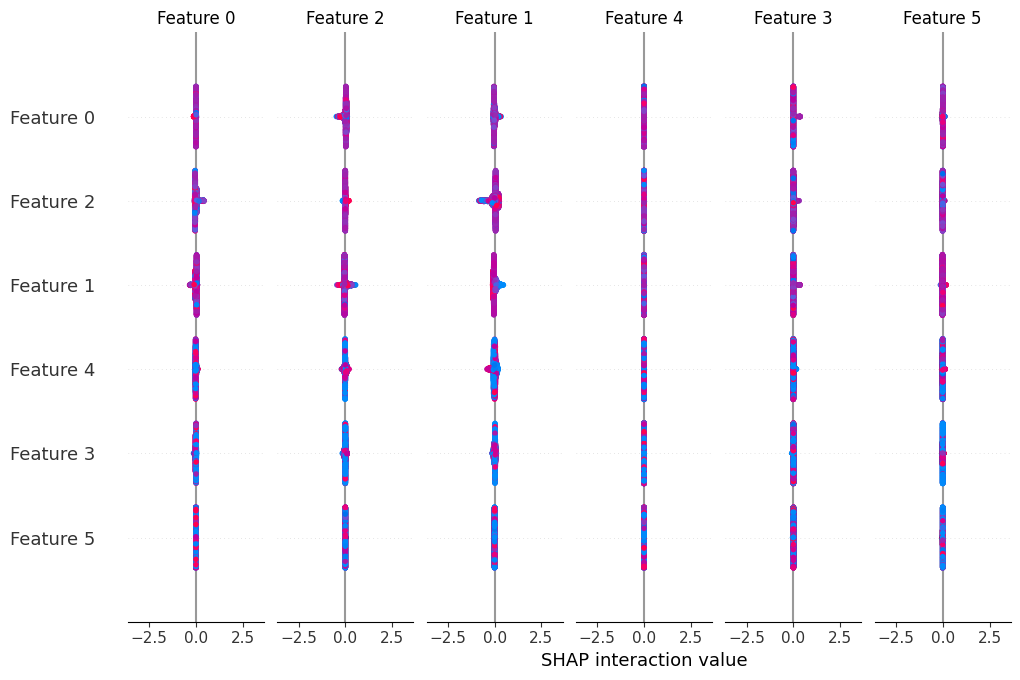

In [25]:
shap.summary_plot(shap_values, X_test)

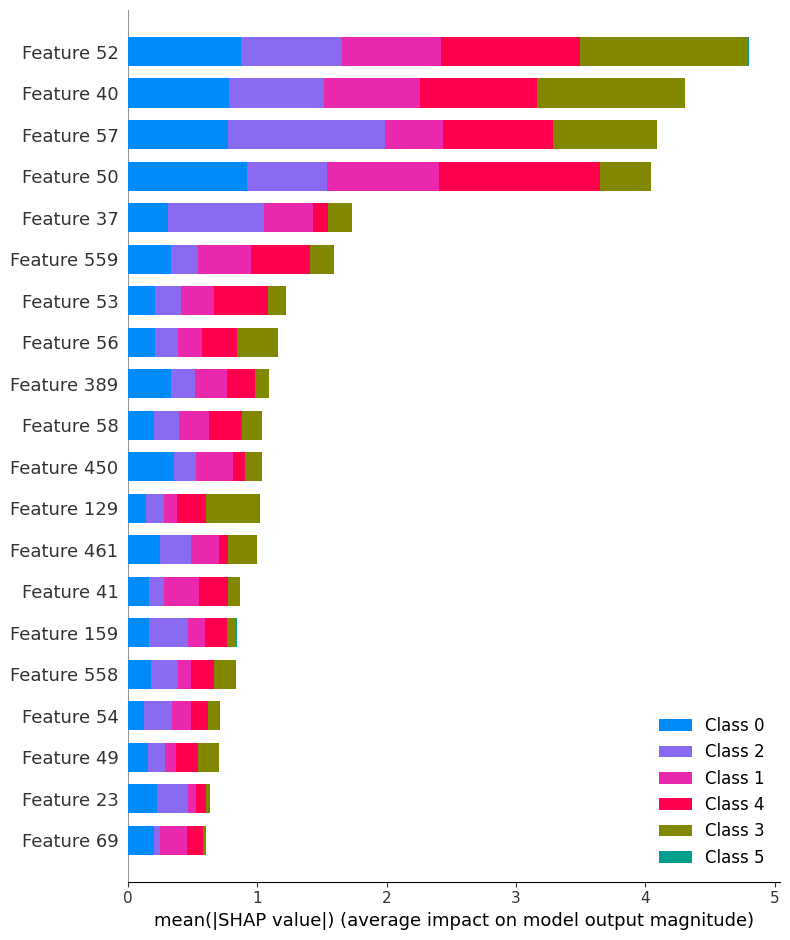

In [27]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

### Conclusion

Your thoughts about the plots and model behaviour:
The model learns very quickly it  captures most of the pstterns in 40-50 iterations then learning is very slow , as we incres number of trees. 

...

In [26]:
import torch
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'